# Vehicle Detection
***

One important aspect of driving is for drivers to remain within their lane. This minimizes the chances of collisions with other cars. As humans, we are able to do this quite naturally. For computers, this isn't quite so easy. The first part of this is to detect driving lanes. In this project, we demonstrate one approach for detecting driving lanes using some well known computer vision techniques. Below, we describe each of these techniques in detail and show how they can be applied using a combination of Python and OpenCV to detect driving lanes.  

---

## Admin

import packages

In [1]:
# standard packages
import numpy as np
import os

# image processing packages
import cv2

# visualization packages
import matplotlib.pyplot as plt

set params

In [2]:
# show plots inline
%matplotlib inline

---

## General Approach 

There are a number of ways to detect driving lanes from images and the following is one such (relatively simple) approach: 

1. Camera calibration
2. RGB to HSL
3. Gaussian blur
4. Thresholding
5. Perspective transform
6. Detect lane lines
7. Measuring curvature
8. Overlay detection on original image

We'll start by developing a pipeline using individual images. Later we show how this can easily be extended to videos (which are really just a series of images). We will use the following sample images for developing and testing our pipelines.  

In [16]:
test_img_dir = "test_images/"

test_image_names = (
    sorted(
        os.listdir(test_img_dir)
    )
)

test_image_paths = list(
    map(lambda x: test_img_dir + x, 
        test_image_names))

In [17]:
def show_image_list(img_list, 
                    cols=2, 
                    fig_size=(10, 10),
                    img_labels=None, 
                    cmap=None):
    
    """
    Show a list of images
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    plt.figure(figsize=fig_size)
        
    for i in range(0, img_count):

        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
                
        # no ticks on axes
        plt.xticks([])
        plt.yticks([])
        
        # plot title
        plt.title(img_name)    
        
        # show plot 
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

In [18]:
def load_image(image_path): 
    """
    load images in RGB format
    """
    
    imgBGR = cv2.imread(image_path)
    
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    return imgRGB

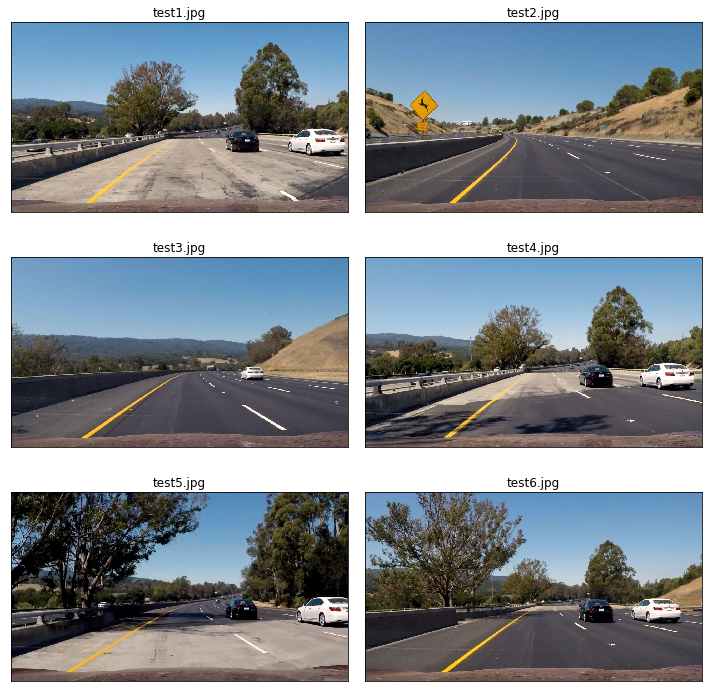

In [19]:
test_images = list(
    map(lambda img: load_image(img), 
        test_image_paths)
)

show_image_list(
    img_list = test_images, 
    img_labels = test_image_names
)

There are few immediately obvious challenges we need to be mindful of while building a generalized pipeline for deteting lanes in these images:  

1. While the lane lines are generally coloured white, they can also be yellow. 
2. While most of these images depict only light traffic, some of them have other cars in them and what's worse is that some cars are colored white! 
3. All of these images depict fairly straight patches of road. It is obviously possible for roads and therefore our lane lines to be curved.   

These are good things to know. Let's start building our pipeline. For testing our pipeline, we'll use just the first image (shown below).  

In [97]:
# test_image = test_images[5]

# plt.imshow(test_image)

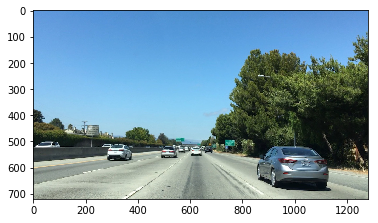

In [96]:
test_image = load_image('bbox-example-image.jpg')

plt.imshow(test_image)

---
## Load cars and not-cars data

In [149]:
def temp_function(test_dir): 
    
    image_names = os.listdir(test_dir)
    
    image_paths = list(map(
        lambda x: test_dir + x, 
        image_names
    ))

    images = list(map(
        lambda x: load_image(x), 
        image_paths
    ))
    
    return images

In [150]:
cars = temp_function('vehicles_smallset/cars1/')
notcars = temp_function('non_vehicles_smallset/notcars1/')

In [153]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    
    data_dict = {}
    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = car_list[0].shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = type(car_list[0])
    
    # Return data_dict
    return data_dict

In [154]:
data_info = data_look(cars, notcars)

print(
    'Your function returned a count of', 
    data_info["n_cars"], ' cars and', 
    data_info["n_notcars"], 
    ' non-cars'
)

print(
    'of size: ',data_info["image_shape"], 
    ' and data type:', 
    data_info["data_type"]
)

Your function returned a count of 397  cars and 399  non-cars
of size:  (64, 64, 3)  and data type: <class 'numpy.ndarray'>


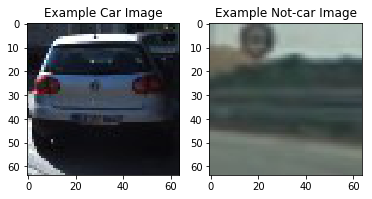

In [155]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cars[car_ind]
notcar_image = notcars[notcar_ind]

# Plot the examples
fig = plt.figure()

plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

---

## Camera calibration

The process by which cameras produce 2D images of 3D objects isn't perfect; the shape and size of objects can change. Below is an example of a distorted image taken by a camera (left) and the same image undistorted (right).  

<figure>
 <img src="writeup_images/chessboard_undistort.jpg"/>
 <figcaption>
 <p></p> 
     
Before we can do anything, we need to first deal with this distortion. Specifically, we will use images of chessboards taken by our camera to figure out it's calibration. After that, we can undistort any image taken by our particular camera. This will allow us to get accurate and useful information out of them later on when perform lane line detection. 

In [52]:
# read in camera calibration images from directory

# img dir
camera_cal_img_dir = "camera_cal/"

# img names
camera_cal_image_names = (
    sorted(
        os.listdir(camera_cal_img_dir)
    )
)

# image paths
camera_cal_image_paths = list(
    map(lambda name: camera_cal_img_dir + name, 
        camera_cal_image_names)
)

# images
camera_cal_images = list(
    map(lambda img: load_image(img), 
        camera_cal_image_paths)
)

In [53]:
# show_image_list(
#     img_list = camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

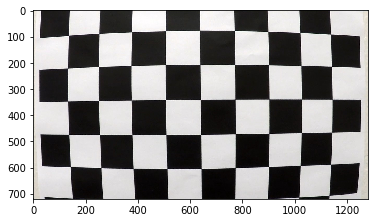

In [54]:
plt.imshow(camera_cal_images[0])

In [55]:
# grayscale images
gray_camera_cal_images = [
    cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in camera_cal_images
]

# set chessboard dimensions
dims = (9,6)

# find chessboard corners
chessboard_corners = [
    cv2.findChessboardCorners(image, dims, None) for image in gray_camera_cal_images
]

In [56]:
# verify chessboard corners have been correctly identified
# plt.imshow(
#     cv2.drawChessboardCorners(
#     camera_cal_images[0], 
#     dims, 
#     *chessboard_corners[0][::-1])
# )

Calculate correct camera matrix and distortion coefficients

In [57]:
# object points
objp = np.zeros(
    (np.prod(dims), 3), 
    np.float32
)

objp[:,:2] = np.mgrid[0:dims[0], 0:dims[1]].T.reshape(-1,2)

objpoints = [
    objp for corner_set in chessboard_corners if corner_set[0]
]

# image points
imgpoints = [
    corner_set[1] for corner_set in chessboard_corners if corner_set[0]
]

# extract camera calibration paramets
ret, mtx, dist, rvecs, tvecs = (
    cv2.calibrateCamera(
        objpoints, 
        imgpoints, 
        gray_camera_cal_images[0].shape[::-1], 
        None, 
        None)
)

In [58]:
def undistort(img, mtx, dist): 
    """
    undistort camera images
    """
    undistorted_img = cv2.undistort(
        img, 
        mtx, 
        dist, 
        None, 
        mtx
    )
    
    return undistorted_img

In [59]:
undistorted_camera_cal_images = list(
    map(lambda img: undistort(img, mtx, dist), 
        camera_cal_images)
)

In [60]:
# show_image_list(
#     img_list = undistorted_camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

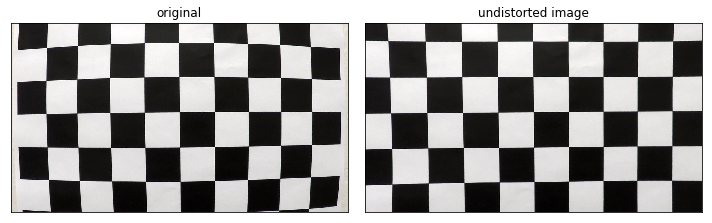

In [61]:
show_image_list(
    img_list=[
        camera_cal_images[0], undistorted_camera_cal_images[0], 
    ],
    img_labels=[
        'original', 'undistorted image'
    ], 
    cmap='gray',
    cols=2
)

Let's undistort our actual driving images. 

In [62]:
undistorted_image = undistort(
    img=test_image, 
    mtx=mtx, 
    dist=dist
)

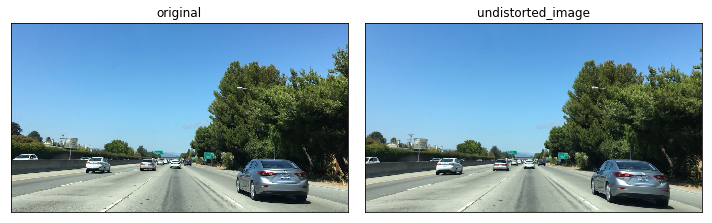

In [63]:
show_image_list(
    img_list=[
        test_image, undistorted_image, 
    ],
    img_labels=[
        'original', 'undistorted_image'
    ], 
    cmap='gray',
    cols=2
)

---
## Manual vehicle detection

We want to be able to draw a box around car in an image. Each box should be centered on a car and the whole car should fit tightly within the box. 

Eventually, we'll have an algorithm that outputs bounding box positions for each car in an image. For now, we'll start off by playing the part of a human vehicle doctor and draw boxes around our cars manually. At that point, we can use our draw_boxes functions to easily plot boxes over our images. 

In [64]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Define a function that takes an image, a list of bounding boxes, 
    # and optional color tuple and line thickness as inputs
    # then draws boxes in that color on the output
    
    # make a copy of the image
    imcopy = np.copy(img)
    
    # iterate through the list of bounding boxes
    for bbox in bboxes:
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # return the image copy with boxes drawn
    return imcopy

Lets test out our function.  

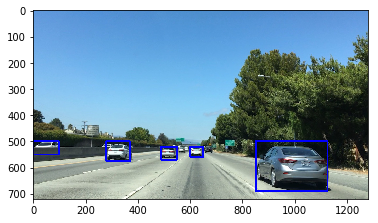

In [93]:
bboxes = [
    # Add bounding boxes in the following format
    # ((top_left_x, top_left_y), (bottom_right_x, bottom_right_y))
    ((850, 500), (1125, 690)), 
    ((280, 500), (370, 575)), 
    ((490, 520), (550, 570)), 
    ((600, 520), (650, 560)), 
    ((0, 500), (100, 550)), 
    ]

result = draw_boxes(test_image, bboxes)
plt.imshow(result)

Excellent, our function works well. Now, let's see if we can build an algorithm that will identify which parts of our image are a car.  

---
## Template matching

Template Matching is a method for searching and finding the location of a template image in a larger image. OpenCV comes with a function cv2.matchTemplate() for this purpose. It simply slides the template image over the input image (as in 2D convolution) and compares the template and patch of input image under the template image. Several comparison methods are implemented in OpenCV. It returns a grayscale image, where each pixel denotes how much does the neighbourhood of that pixel match with template.

If input image is of size (WxH) and template image is of size (wxh), output image will have a size of (W-w+1, H-h+1). Once you got the result, you can use cv2.minMaxLoc() function to find where is the maximum/minimum value. Take it as the top-left corner of rectangle and take (w,h) as width and height of the rectangle. That rectangle is your region of template.  

In [102]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns a list of bounding boxes 
# for matched templates
def find_matches(img, template_images):
    
    # Make a copy of the image to draw on
    draw_img = np.copy(img)
    
    # Define an empty list to take bbox coords
    bbox_list = []
    
    # Iterate through template list
    for template_image in template_images: 

        h, w, c = template_image.shape
        
        # Use cv2.matchTemplate() to search the image
        # using whichever of the OpenCV search methods you prefer
    
        result = cv2.matchTemplate(
            image=img, 
            templ=template_image, 
            method=cv2.TM_CCOEFF_NORMED
            )
    
        # Use cv2.minMaxLoc() to extract the location of the best match
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
        
        # Determine bounding box corners for the match
        top_left = maxLoc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        
        box = (top_left, bottom_right)
        
        bbox_list.append(box)
        
    # Return the list of bounding boxes
    return bbox_list

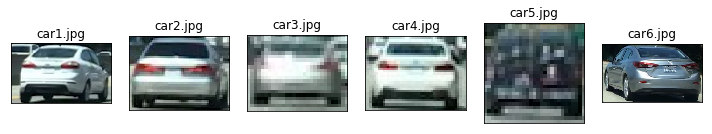

In [106]:
# read in template images from directory

# img dir
template_images_dir = 'template_cars/'

# img names
template_image_names = (
    sorted(
        os.listdir(template_images_dir)
    )
)

# image paths
template_image_paths = list(
    map(lambda x: template_images_dir + x, 
        template_image_names)
)

# images
template_images = list(
    map(lambda img: load_image(img), 
        template_image_paths)
)

show_image_list(
    img_list=template_images, 
    img_labels=template_image_names, 
    cols = 6
)

Let's test our function.  

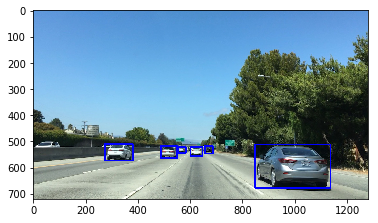

In [107]:
bboxes = find_matches(test_image, template_images)
result = draw_boxes(test_image, bboxes)

plt.imshow(result)

That worked rather well. Let's see how this works on the next frame of the video.  

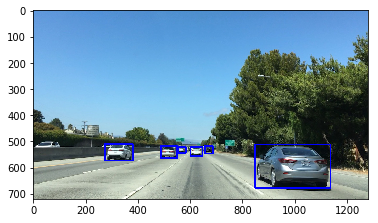

In [108]:
bboxes = find_matches(test_image, template_images)
result = draw_boxes(test_image, bboxes)

plt.imshow(result)

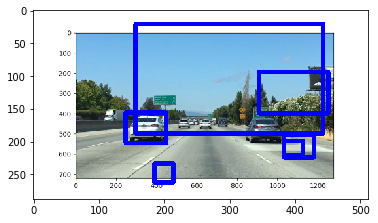

In [157]:
image = load_image('bbox-example-image-2.png')

bboxes = find_matches(image, template_images)
result = draw_boxes(image, bboxes)

plt.imshow(result)

Well, that's just awful. It's the same cars in the image. But because the cars are positioned sligly differently, our method fails.  

Here's the other issue, this method won't generalise well to cars not present in our templates. If for example, we don't have a template picture of a Toyota Corolla 1999, this method would surely fail. 

Template matching depends on raw color values laid out in a specific sequence. This can vary a lot from car to car. Really, we need to find some transformations that are robust to changes in appearances. We look at one such transformation next.  

---
## Color histogram  

When you compare the color histogram of a known object with regions of a template image, locations with similar color distributions will reveal a close match. With this method, we've removed our dependence ons structure, that is to say we're no longer sensitive to a perfect arrangement (or sequence) of pixels.   

In [110]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately
    # Take histograms in R, G, and B
    rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    
    return rhist, ghist, bhist, bin_centers, hist_features

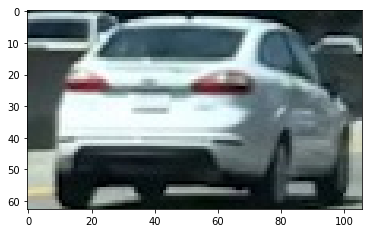

In [112]:
plt.imshow(template_images[0])

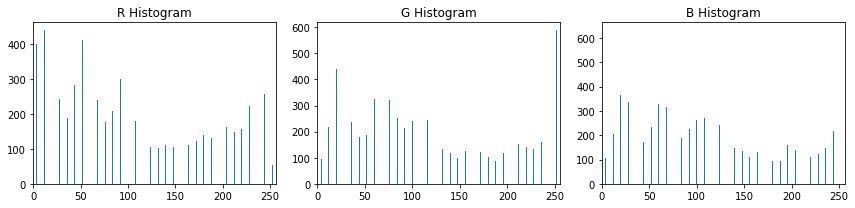

In [111]:
rh, gh, bh, bincen, feature_vec = color_hist(template_images[0], nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

Let's formalize this as a function.  

In [551]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

One of the issues we saw with template matching was that even if we had the exact same car but at a slight distance, our algorithm would fail to pick it up as the car was now smaller than in our template image. As it is, this method will also fail to work in these cases unless we normalize our histograms. This way, we can accomodate for the same of image of a car at different scales.  

One of the obvious downsides of using this as a comparison method is that we might still match with unwanted regions that have a similar color distribution. One option for remedying this is finding histogram distributions in color spaces where cars are clearly differentiated from non-cars. We look at this next.  

---

## Explore color spaces

There are a number of color models, below is a brief introduction to two of the most popular models in use today.   

#### RGB 

The most commonly used model is the RGB model which defines a color space in terms of three components:

- Red, which ranges from 0-255
- Green, which ranges from 0-255
- Blue, which ranges from 0-255

The RGB color model is additive i.e. Red, Green and Blue values are combined to reproduce other colors. 

<figure>
 <img src="writeup_images/rgb.png" width = "100"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> RGB color model </p> 

#### HLS 

The HLS color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Lightness (also Luminance or Luminosity or Intensity). Ranges from 0 to 100% (from black to white).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).


<figure>
 <img src="writeup_images/hsl.png" width = 100/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HLS color model</p> 
     
#### HSV 

The HSV color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).  
- Value: xxx

<figure>
 <img src="writeup_images/hsv.png" width = 100 />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HSV color model </p> 


There are other color models out there too including CMYK, and YUV. Like most images however, all of our images are in RBG format. So why are we talking about other color models? We suspect that it might be easier to isolate driving lanes in other color spaces than RGB. So let's have a look at our test images in HSL.    

In [114]:
from mpl_toolkits.mplot3d import Axes3D

In [115]:
def plot3d(
    pixels, 
    colors_rgb,
    axis_labels=list("RGB"), 
    axis_limits=((0, 255), (0, 255), (0, 255))
    ):
    """Plot pixels in 3D."""

    # Create figure and 3D axes


    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

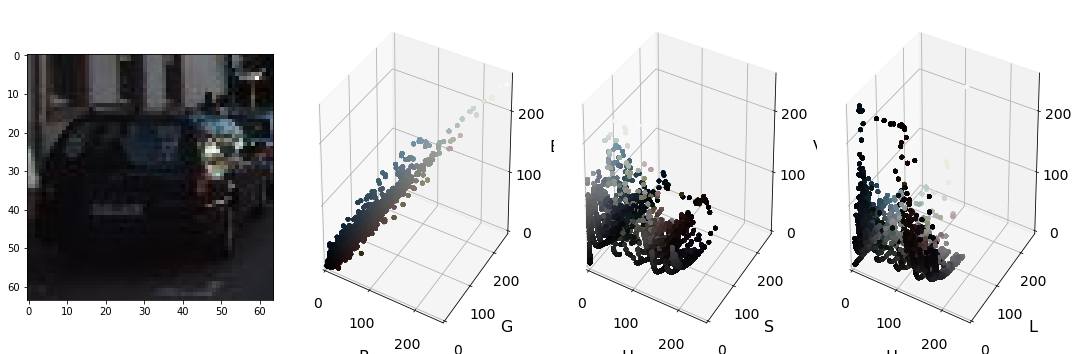

In [159]:
# Select a small fraction of pixels to plot by subsampling it
scale = max(
    cars[0].shape[0], 
    cars[0].shape[1],
    64) / 64  # at most 64 rows and columns

img_small = cv2.resize(
    cars[0], 
    (np.int(image.shape[1] / scale), np.int(image.shape[0] / scale)), 
    interpolation=cv2.INTER_NEAREST
)

# Convert subsampled image to desired color space(s)
# OpenCV uses BGR, matplotlib likes RGB
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_RGB = img_small
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(cars[0])

ax = fig.add_subplot(1, 4, 2, projection='3d')
ax = plot3d(
    pixels = img_small_RGB, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("RGB")
)

ax = fig.add_subplot(1, 4, 3, projection='3d')
ax = plot3d(
    pixels = img_small_HSV, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HSV")
)

ax = fig.add_subplot(1, 4, 4, projection='3d')
ax = plot3d(
    pixels = img_small_HLS, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HLS")
)

plt.tight_layout(pad=1, w_pad=1, h_pad=1)

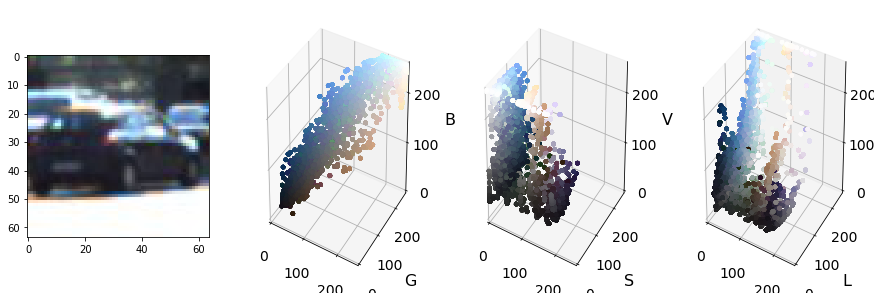

In [160]:
# Select a small fraction of pixels to plot by subsampling it
scale = max(
    cars[1].shape[0], 
    cars[1].shape[1],
    64) / 64  # at most 64 rows and columns

img_small = cv2.resize(
    cars[1], 
    (np.int(image.shape[1] / scale), np.int(image.shape[0] / scale)), 
    interpolation=cv2.INTER_NEAREST
)

# Convert subsampled image to desired color space(s)
# OpenCV uses BGR, matplotlib likes RGB
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_RGB = img_small
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(cars[1])

ax = fig.add_subplot(1, 4, 2, projection='3d')
ax = plot3d(
    pixels = img_small_RGB, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("RGB")
)

ax = fig.add_subplot(1, 4, 3, projection='3d')
ax = plot3d(
    pixels = img_small_HSV, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HSV")
)

ax = fig.add_subplot(1, 4, 4, projection='3d')
ax = plot3d(
    pixels = img_small_HLS, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HLS")
)

Let's see what a non-car image looks like.  

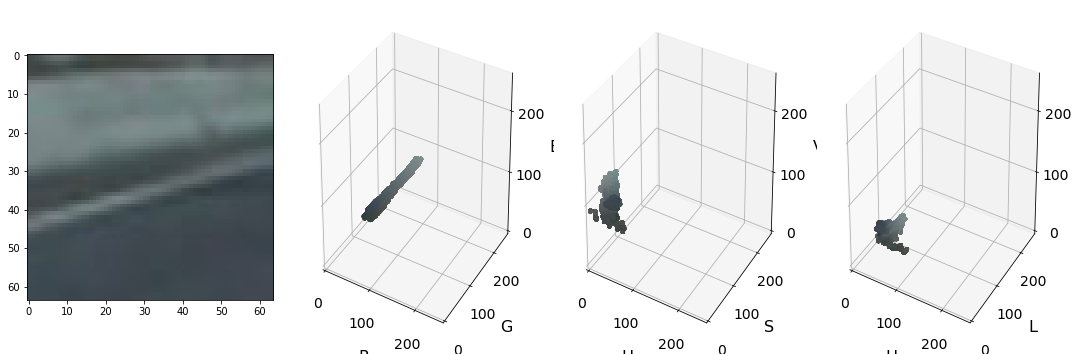

In [158]:
# Select a small fraction of pixels to plot by subsampling it
scale = max(
    notcars[0].shape[0], 
    notcars[0].shape[1],
    64) / 64  # at most 64 rows and columns

img_small = cv2.resize(
    notcars[0], 
    (np.int(image.shape[1] / scale), np.int(image.shape[0] / scale)), 
    interpolation=cv2.INTER_NEAREST
)

# Convert subsampled image to desired color space(s)
# OpenCV uses BGR, matplotlib likes RGB
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_RGB = img_small
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(notcars[0])

ax = fig.add_subplot(1, 4, 2, projection='3d')
ax = plot3d(
    pixels = img_small_RGB, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("RGB")
)

ax = fig.add_subplot(1, 4, 3, projection='3d')
ax = plot3d(
    pixels = img_small_HSV, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HSV")
)

ax = fig.add_subplot(1, 4, 4, projection='3d')
ax = plot3d(
    pixels = img_small_HLS, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HLS")
)

plt.tight_layout(pad=1, w_pad=1, h_pad=1)

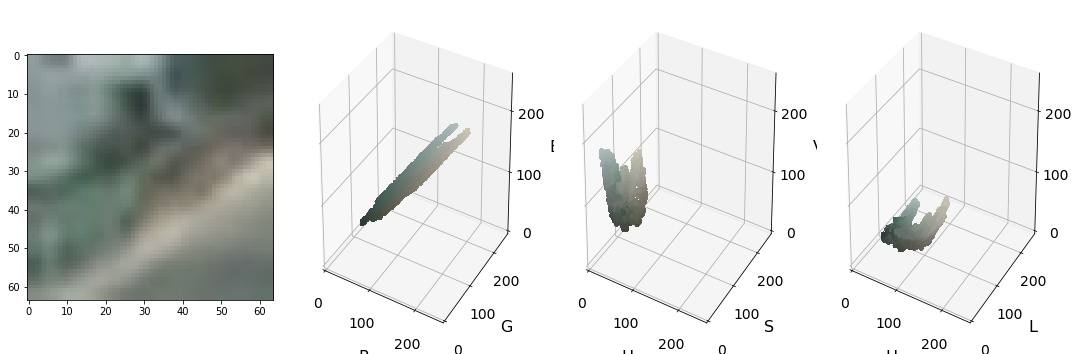

In [161]:
# Select a small fraction of pixels to plot by subsampling it
scale = max(
    notcars[1].shape[0], 
    notcars[1].shape[1],
    64) / 64  # at most 64 rows and columns

img_small = cv2.resize(
    notcars[1], 
    (np.int(image.shape[1] / scale), np.int(image.shape[0] / scale)), 
    interpolation=cv2.INTER_NEAREST
)

# Convert subsampled image to desired color space(s)
# OpenCV uses BGR, matplotlib likes RGB
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_RGB = img_small
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(notcars[1])

ax = fig.add_subplot(1, 4, 2, projection='3d')
ax = plot3d(
    pixels = img_small_RGB, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("RGB")
)

ax = fig.add_subplot(1, 4, 3, projection='3d')
ax = plot3d(
    pixels = img_small_HSV, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HSV")
)

ax = fig.add_subplot(1, 4, 4, projection='3d')
ax = plot3d(
    pixels = img_small_HLS, 
    colors_rgb = img_small_rgb, 
    axis_labels=list("HLS")
)

plt.tight_layout(pad=1, w_pad=1, h_pad=1)

Car color features tend to be clustered in the RGB space. In the HLS space though, 

tend to be clearly differentiated from the background in HSL space.  

Car images tend to be more saturated.  

## Spatial binning features

We saw earlier that template matching isn't a particularly robust method for finding vehicles unless you know exactly what your target object looks like. However, raw pixel values are still quite useful to include in your feature vector when searching for cars. 

Depending on the size of your image, it can be cumbersome to include three color channels of a full resolution image. Instead, you can perform spatial binning on an image and still retain enough information to help in finding vehicles, like so: 

<figure>
 <img src="writeup_images/spatial_binning.jpg" />
 <figcaption>
 <p></p> 

As you can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.

In [142]:
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    img_small = cv2.resize(
        img, 
        size, 
        interpolation=cv2.INTER_NEAREST
    )
    
    # convert matrix to feature vector
    features = img_small.ravel() 
    
    return features

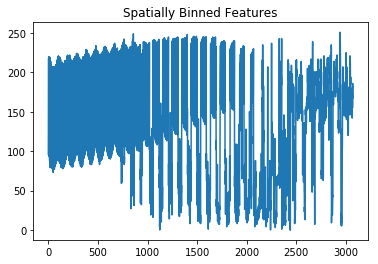

In [144]:
feature_vec = bin_spatial(test_image, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

So far we've been transforming color values into a variety of different feature vectors. While these are useful, we're missing out on a whole wealth of information, specifically as they relate to object structure. We look at some methods for capturing this kind of information next. 

## HOG features

Here is a [presentation](https://www.youtube.com/watch?v=7S5qXET179I) on using Histogram of Oriented Gradient (HOG) features for pedestrian detection by Navneet Dalal, the original developer of HOG for object detection, as well as his original [paper](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) on the topic.  

Below we show HOG for a sample image.  

In [162]:
from skimage.feature import hog
from skimage import color, exposure

In [163]:
# Define a function to return HOG features and visualization
def get_hog_features(
    img, 
    orient, 
    pix_per_cell, 
    cell_per_block, 
    vis=False, 
    feature_vec=True
    ):
    
    if vis==True:
        
        features, hog_image = hog(
            image=img, 
            orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=True,
            feature_vector=True                     
        )
        
        return features, hog_image
    
    else:      
        
        features = hog(
            image=img, 
            orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=False,
            feature_vector=True                     
        )
        
        return features

In [164]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in the image
image = cars[ind]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(
    img = gray, 
    orient = 9, 
    pix_per_cell = 8, 
    cell_per_block = 2, 
    vis = True, 
    feature_vec = False
)

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


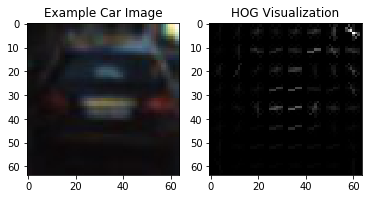

In [165]:
# Plot the examples
fig = plt.figure()

plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

---
## Combine features

We've got several feature extraction methods in our toolkit now. To recap, we have:  
- color histogram  
- spatial binning  
- histogram oriented gradients  

As we've already discussed, each of them is good for capturing a different aspect of our images. We'll probably want to use all of them when training our classifier. So let's write a function that will extract all of these features from an image.  

In [420]:
# Define a function to extract features from a list of images
def extract_features(
    img, 
    cspace='RGB', 
    spatial_size=(32, 32),
    hist_bins=32, 
    hist_range=(0, 256)
    ):
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(
        img, 
        size=spatial_size
    )
        
    # Apply color_hist() to get color histogram features
    rhist, ghist, bhist, bin_centers, hist_features = color_hist(
        img, 
        nbins=hist_bins, 
        bins_range=hist_range
    )
        
    # feature vector
    features = np.concatenate(
        (spatial_features, hist_features)
    )
    
    # Return list of feature vectors
    return features

In [394]:
car_features = list(map(
    lambda x: 
    extract_features(
        x, 
        cspace='RGB', 
        spatial_size=(32, 32),
        hist_bins=32, 
        hist_range=(0, 256)
    ), 
    cars
))

notcar_features = list(map(
    lambda x: 
    extract_features(
        x, 
        cspace='RGB', 
        spatial_size=(32, 32),
        hist_bins=32, 
        hist_range=(0, 256)
    ), 
    notcars
))

In [402]:
from sklearn.preprocessing import StandardScaler

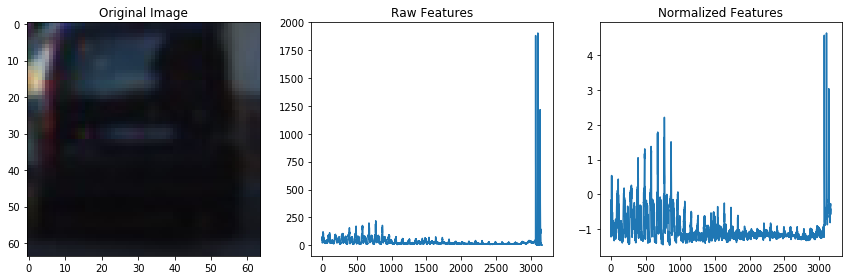

In [404]:
if len(car_features) > 0:
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cars[car_ind])
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    
else: 
    
    print('Your function only returns empty feature vectors...')

## Color features classifier

In [406]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [408]:
from sklearn.model_selection import train_test_split

In [410]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 3168


In [414]:
from sklearn.svm import LinearSVC
import time

In [415]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

0.47 Seconds to train SVC...


In [416]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9625
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00125 Seconds to predict 10 labels with SVC


Play with the parameter values spatial and histbin in the exercise below to see how the classifier accuracy and training time vary with the feature vector input.

Warning: when dealing with image data that was extracted from video, you may be dealing with sequences of images where your target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set. For the subset of images used in the next several quizzes, this is not a problem, but to optimize your classifier for the project, you may need to worry about time-series of images!


## HOG features classifier

In [427]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()

car_features = list(map(
    lambda x: 
    get_hog_features(
        img =  cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), 
        orient = 9, 
        pix_per_cell = 8, 
        cell_per_block = 2, 
        vis = False, 
        feature_vec = True
    ), 
    cars
))

notcar_features = list(map(
    lambda x: 
    get_hog_features(
        img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), 
        orient = 9, 
        pix_per_cell = 8, 
        cell_per_block = 2, 
        vis = False, 
        feature_vec = True
    ), 
    notcars
))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.77 Seconds to extract HOG features...


In [428]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [429]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764


In [430]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9562
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  1.  1.  0.]
0.002 Seconds to predict 10 labels with SVC


## All the features!

In [459]:
def single_img_features(
    img, 
    color_space='RGB', 
    spatial_size=(32, 32),
    hist_bins=32, 
    orient=9, 
    pix_per_cell=8, 
    cell_per_block=2, 
    hog_channel=0,
    spatial_feat=True, 
    hist_feat=True, 
    hog_feat=True
    ):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Sliding window technique

To implement a sliding window search, you need to decide what size window you want to search, where in the image you want to start and stop your search, and how much you want windows to overlap. So, let's try an example to see how many windows we would be searching given a particular image size, window size, and overlap.

Suppose you have an image that is 256 x 256 pixels and you want to search windows of a size 128 x 128 pixels each with an overlap of 50% between adjacent windows in both the vertical and horizontal dimensions. Your sliding window search would then look like this:

<figure>
 <img src="writeup_images/sliding_window.jpg"/>
 <figcaption>
 <p></p>  
     
In the last exercise, you saw how the number of windows scales with image size, window size, and overlap. In the project it will be useful to have a function to perform a sliding window search on an image, so let's write one! This will just be the first iteration, where you don't actually need to do anything besides plot a rectangle at each window position.

So, your goal here is to write a function that takes in an image, start and stop positions in both x and y (imagine a bounding box for the entire search region), window size (x and y dimensions), and overlap fraction (also for both x and y). Your function should return a list of bounding boxes for the search windows, which will then be passed to draw draw_boxes() function.

In [451]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(
    img, 
    x_start_stop=[None, None], 
    y_start_stop=[None, None], 
    xy_window=(64, 64), 
    xy_overlap=(0.5, 0.5)
    ):
    
    # img dimensions
    h, w, c = img.shape
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
        
    if x_start_stop[1] == None:
        x_start_stop[1] = w
        
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
        
    if y_start_stop[1] == None:
        y_start_stop[1] = h
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows    
    return window_list

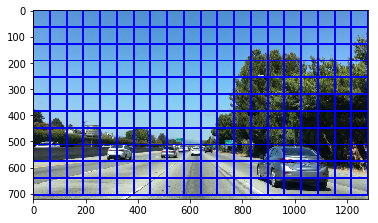

In [453]:
windows = slide_window(
    image, 
    x_start_stop=[None, None], 
    y_start_stop=[None, None], 
    xy_window=(128, 128), 
    xy_overlap=(0.5, 0.5)
)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Multiscale windows

## Searching in windows

In this exercise, experiment with different color and gradient feature sets, different search window sizes and overlap to get an idea of how your classifier performs with different training features. Getting false positives in the skies and treetops? Try restricting your search area on the image with y_start_stop in the slide_window() function. What combination of features works best?

In [571]:
def single_img_features(
    img, 
    color_space='RGB', 
    spatial_size=(32, 32),
    hist_bins=32, 
    orient=9, 
    pix_per_cell=8, 
    cell_per_block=2, 
    hog_channel=0,
    spatial_feat=True, 
    hist_feat=True, 
    hog_feat=True
    ):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [572]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

y_start_stop = [500, 700] # Min and max in y to search in slide_window()

In [573]:
car_features = list(map(
    lambda x: 
    single_img_features(
        img=x, 
        color_space=color_space, 
        spatial_size=spatial_size, 
        hist_bins=hist_bins,
        orient=orient, 
        pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, 
        spatial_feat=spatial_feat, 
        hist_feat=hist_feat, 
        hog_feat=hog_feat
    ), 
    cars
))

notcar_features = list(map(
    lambda x: 
    single_img_features(
        img=x, 
        color_space=color_space, 
        spatial_size=spatial_size, 
        hist_bins=hist_bins,
        orient=orient, 
        pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, 
        spatial_feat=spatial_feat, 
        hist_feat=hist_feat, 
        hog_feat=hog_feat
    ), 
    notcars
))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [574]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [575]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, 
    test_size=0.2, 
    random_state=rand_state)

print(
    'Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')

print(
    'Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580


In [576]:
clf = LinearSVC()

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

0.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9875


In [577]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(
    img, 
    windows, 
    clf, 
    scaler, 
    color_space='RGB', 
    spatial_size=(32, 32), 
    hist_bins=32, 
    hist_range=(0, 256), 
    orient=9, 
    pix_per_cell=8, 
    cell_per_block=2, 
    hog_channel=0, 
    spatial_feat=True, 
    hist_feat=True, 
    hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(
            test_img, 
            color_space=color_space, 
            spatial_size=spatial_size, 
            hist_bins=hist_bins, 
            orient=orient, 
            pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, 
            spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat
        )
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


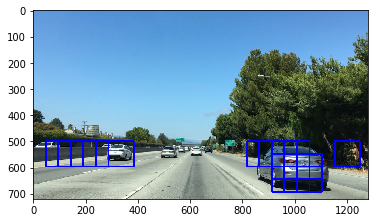

In [578]:
# Check the prediction time for a single sample
t=time.time()

test_image = load_image('bbox-example-image.jpg')

draw_image = np.copy(test_image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(
    test_image, 
    x_start_stop=[None, None], 
    y_start_stop=y_start_stop, 
    xy_window=(96, 96), 
    xy_overlap=(0.5, 0.5)
)

hot_windows = search_windows(
    img=test_image, 
    windows=windows, 
    clf=clf, 
    scaler=X_scaler, 
    color_space=color_space, 
    spatial_size=spatial_size, 
    hist_bins=hist_bins, 
    orient=orient, 
    pix_per_cell=pix_per_cell, 
    cell_per_block=cell_per_block, 
    hog_channel=hog_channel, 
    spatial_feat=spatial_feat, 
    hist_feat=hist_feat, 
    hog_feat=hog_feat
)                       

window_img = draw_boxes(
    draw_image, 
    hot_windows, 
    color=(0, 0, 255), 
    thick=6
)                    

plt.imshow(window_img)

## Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. The code below defines a single function find_cars that's able to both extract features and make predictions.

The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [582]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [594]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


In [595]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [596]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [609]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [610]:
ystart = 300
ystop = 400
scale = 1.5
    
out_img = find_cars(
    test_image, 
    ystart, 
    ystop, 
    scale, 
    clf, 
    X_scaler, 
    orient, 
    pix_per_cell, 
    cell_per_block, 
    spatial_size, 
    hist_bins
)

plt.imshow(out_img)

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,6108) (2580,) (1,6108) 

Need to make a new X_scaler

## Heat map

In [611]:
from scipy.ndimage.measurements import label

In [617]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

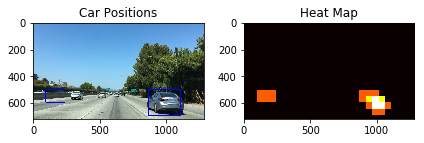

In [619]:
# Add heat to each box in box list
heat = add_heat(
    heat, 
#     box_list
    hot_windows
)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Testing on images

Now let's combine all of the above functions into one with our best parameters.  

In [ ]:
lane_line_detector = Lane_line_detector()

In [ ]:
def process_image(img, show_plots=False):
    """
    One function to rule them all!
    """
    
    # undistory image 
    undistorted_image = undistort(img, mtx, dist)
    
    # convert image to hsl
    hls_s_image = hls(img=undistorted_image, channel='s')
    
    # apply Gaussian smoothing
    blur_image = gaussian_blur(hls_s_image)
    
    # threshold image
    params=[
#     color_threshold(
#         img=blur_image, 
#         thresh=(50,255)
#     ), 
     abs_sobel_thresh(
        img = blur_image, 
        orient = 'y', 
        sobel_kernel = 11, 
        thresh = (10, 255)
    ), 
     mag_threshold(
         img = blur_image, 
         sobel_kernel = 11, 
         thresh = (15, 255)
     ), 
#      dir_threshold(
#          img = blur_image, 
#          sobel_kernel = 9, 
#          thresh = (0.7, 1.3)
#      )
    ]

    threshold_image = combine_thresholds(
        images = [param for param in params]
    )
    
    # warp perspective to top down view
    warped_image = adjustPerspective(threshold_image, M)
    
    # lane on image
    final_image = lane_line_detector.draw_lane(img, warped_image, Minv)
        
    if show_plots==True:

        plt.imshow(image)
        plt.show()
        
        plt.imshow(image_hsl)
        plt.show()
        
        plt.imshow(image_gray, cmap='gray')
        plt.show()
        
        plt.imshow(blur_gray, cmap='gray')
        plt.show()
        
        

    else: 
        return final_image

Lets test our function on all the images to see how well it worked.  

In [ ]:
all_test_images = list(map(lambda img: process_image(img, show_plots=False), 
                           original_images.copy()))

show_image_list(img_list=all_test_images)

## Testing on videos

Drawing lanes over images is pretty cool but drawing lanes over video is awesome!

We'll test our solution on 3 different videos, ordered below by difficulty:

1. `project_video.mp4`

2. `challenge_video.mp4`

3. `harder_challenge_video.mp4`

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_video(video_filepath, video_filename, lane_detector, plot=False):
    
    video_input = VideoFileClip(video_filepath + video_filename)
    video_output = video_input.fl_image(lane_detector)
    video_output.write_videofile(video_filename , audio=False)
    
    HTML(
        """<video width="800" height="400" controls>
        <source src="{0}">
        </video>"""
        .format(video_output)
    )

We'll try the one with the solid white lane on the right first. This is a fairly simple video. 

In [ ]:
process_video("test_videos/", "project_video.mp4", process_image, plot=False)

Now for the challenge video, one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
process_video("test_videos/", "challenge_video.mp4", process_image, plot=False)

Lastly, we'll try the harder challenge video.  

In [ ]:
process_video("test_videos/", "harder_challenge_video.mp4", process_image, plot=False)

Humm the lines in our videos are quite jerky. Let's try and fix that. 